In [1]:
%load_ext autoreload

In [48]:
%autoreload
import astropy.units as u
import cmasher as cmr
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pears
import seaborn as sns
from astropy.coordinates import (
    CartesianRepresentation,
    SkyCoord,
    SphericalRepresentation,
    matrix_utilities,
)
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from IPython.display import HTML
from matplotlib import animation
from tqdm.auto import tqdm

plt.rc("text", usetex=True)


plt.rcParams["axes.labelsize"] = 25
plt.rcParams["axes.titlesize"] = 25
plt.rcParams["xtick.labelsize"] = 25
plt.rcParams["ytick.labelsize"] = 25
plt.rcParams["figure.figsize"] = (11, 7)

SELECT gs.*,
ap."teff_gspspec", 
ap."logg_gspspec",
ap."mh_gspspec", 
ap."alphafe_gspspec",
ap."fem_gspspec", 
ap."mgfe_gspspec", 
ap."sife_gspspec", 
ap."cafe_gspspec", 
ap."tife_gspspec", 
ap."sfe_gspspec",
ap."nfe_gspspec", 
ap."nife_gspspec",
ap."radius_flame",
ap."age_flame", 
ap."mass_flame",
ap."lum_flame",
ap."distance_msc", 
ap."teff_gspspec_lower",
ap."teff_gspspec_upper",
ap."logg_gspspec_lower",
ap."logg_gspspec_upper",
ap."mh_gspspec_lower",
ap."mh_gspspec_upper",
ap."alphafe_gspspec_lower",
ap."alphafe_gspspec_upper",
ap."fem_gspspec_lower",
ap."fem_gspspec_upper",
ap."mgfe_gspspec_lower",
ap."mgfe_gspspec_upper",
ap."sife_gspspec_lower",
ap."sife_gspspec_upper",
ap."cafe_gspspec_lower",
ap."cafe_gspspec_upper",
ap."tife_gspspec_lower",
ap."tife_gspspec_upper",
ap."sfe_gspspec_lower",
ap."sfe_gspspec_upper",
ap."nfe_gspspec_lower",
ap."nfe_gspspec_upper",
ap."nife_gspspec_lower",
ap."nife_gspspec_upper",
ap."radius_flame_lower",
ap."radius_flame_upper",
ap."age_flame_lower",
ap."age_flame_upper",
ap."mass_flame_lower",
ap."mass_flame_upper",
ap."lum_flame_lower",
ap."lum_flame_upper",
ap."distance_msc_lower",
ap."distance_msc_upper",
ap."ag_msc",
ap."ag_msc_lower",
ap."ag_msc_upper",
ap."azero_msc",
ap."azero_msc_upper",
ap."azero_msc_lower",
ap."azero_gspphot",
ap."azero_gspphot_lower",
ap."azero_gspphot_upper"

FROM "gaiadr3"."gaia_source_lite" as gs
LEFT JOIN "gaiadr3"."astrophysical_parameters" as ap
ON gs."source_id" = ap."source_id"
     
WHERE gs."has_xp_sampled" = True 
  AND gs."astrometric_params_solved" = 95
  AND gs."has_rvs" = True
  AND gs."parallax" > 0 
  AND gs."parallax_over_error" > 10

In [33]:
df = pd.read_csv("../data/dr3.csv")

In [34]:
fltr = np.logical_and.reduce(
    (
        ~df["distance_gspphot"].isna(),
        ~df["distance_msc"].isna(),
        df["distance_msc"] < 1000.0,
    )
)
df = df[fltr]

In [35]:
def wrap_at(x, wrap):
    x_copy = np.copy(x)
    mask = x_copy > wrap
    x_copy[mask] = x_copy[mask] - 2.0 * wrap
    return x_copy

([], [])

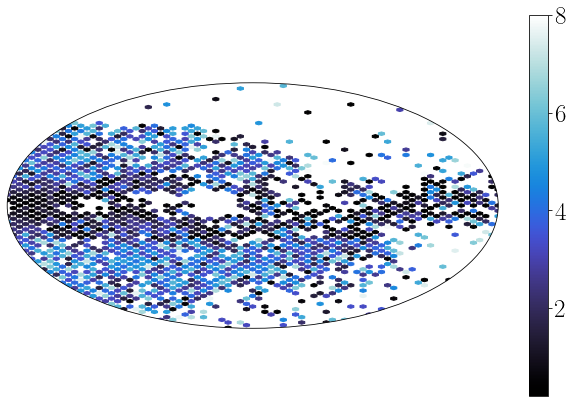

In [102]:
plt.subplot(111, projection="aitoff")
plt.hexbin(
    np.deg2rad(wrap_at(df["l"], 180.0)),
    np.deg2rad(df["b"]),
    C=df["age_flame"],
    cmap=cmr.freeze,
    vmax=8,
    gridsize=80,
)
plt.colorbar()
plt.xticks([])
plt.yticks([])

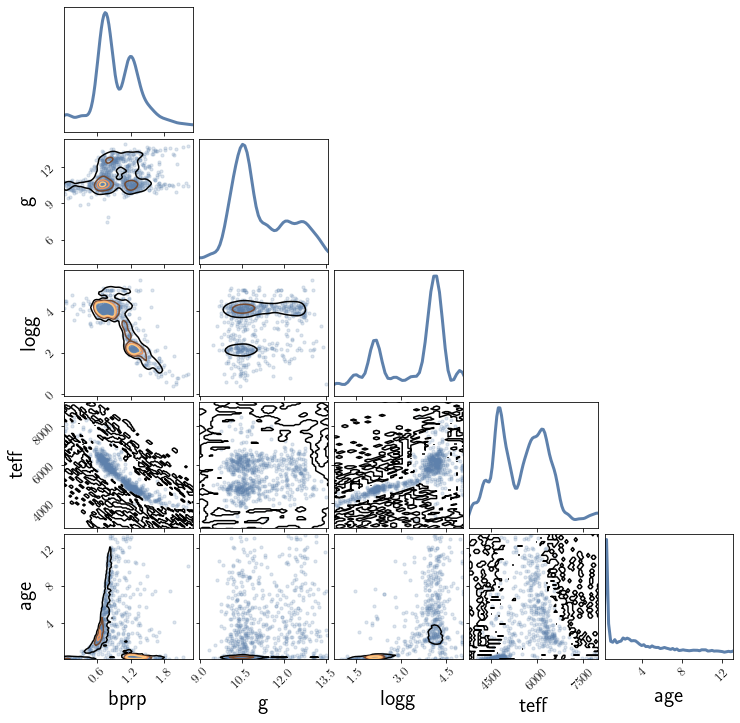

In [115]:
pears(
    dict(
        bprp=df["phot_bp_mean_mag"] - df["phot_rp_mean_mag"],
        g=df["phot_g_mean_mag"],
        logg=df["logg_gspspec"],
        teff=df["teff_gspspec"],
        age=df["age_flame"],
    ),
    scatter_thin=20,
    xlim_quantiles=(0.01, 0.99),
);

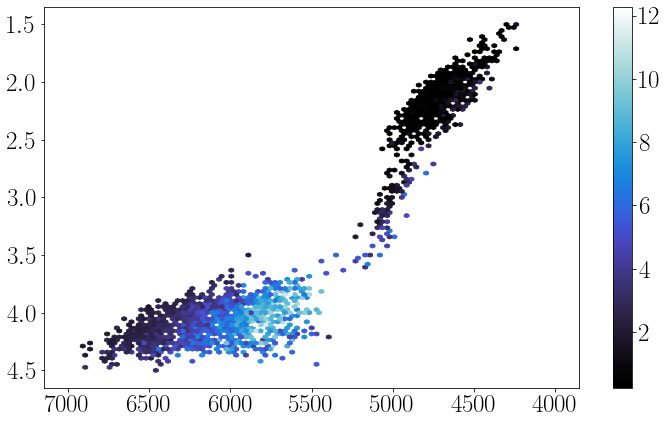

In [124]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot()
sc = ax.hexbin(
    df["teff_gspspec"],
    df["logg_gspspec"],
    C=df["age_flame"],
    gridsize=100,
    cmap=cmr.freeze,
    mincnt=3,
    extent=[4000, 7000, 1.5, 4.5],
)
ax.invert_xaxis()
ax.invert_yaxis()
fig.colorbar(sc)

In [38]:
coords = SkyCoord(
    ra=u.Quantity(df["ra"], u.deg),
    dec=u.Quantity(df["dec"], u.deg),
    distance=u.Quantity(df["distance_msc"], u.pc),
    # distance=u.Quantity(df['parallax'], u.mas).to(u.pc, u.parallax()),
    pm_ra_cosdec=u.Quantity(df["pmra"] * np.cos(np.deg2rad(df["dec"])), u.mas / u.yr),
    pm_dec=u.Quantity(df["pmdec"], u.mas / u.yr),
    radial_velocity=u.Quantity(df["radial_velocity"], u.km / u.s),
    frame="icrs",
)
gc = coords.galactocentric
radius = np.sqrt(np.sum(np.square(gc.cartesian.xyz[:2]), axis=0))

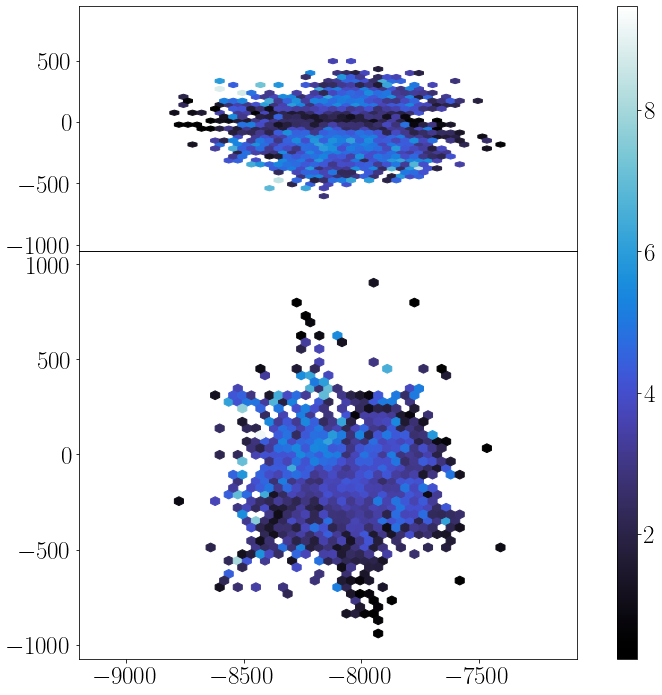

In [100]:
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(
    2, 3, width_ratios=[5, 0.4, 0.2], height_ratios=[3, 5], wspace=0.0, hspace=0
)

args = dict(C=df["age_flame"], gridsize=50, cmap=cmr.freeze, mincnt=3)
ax0 = fig.add_subplot(gs[1, 0])
sc = ax0.hexbin(gc.x, gc.y, **args)

ax_top = fig.add_subplot(gs[0, 0], sharex=ax0)
ax_top.hexbin(gc.x, gc.z, **args)
ax_top.xaxis.set_visible(False)

cbarax = fig.add_subplot(gs[:, -1])

fig.colorbar(sc, cax=cbarax)

Text(0, 0.5, '[$\\alpha$/Fe]')

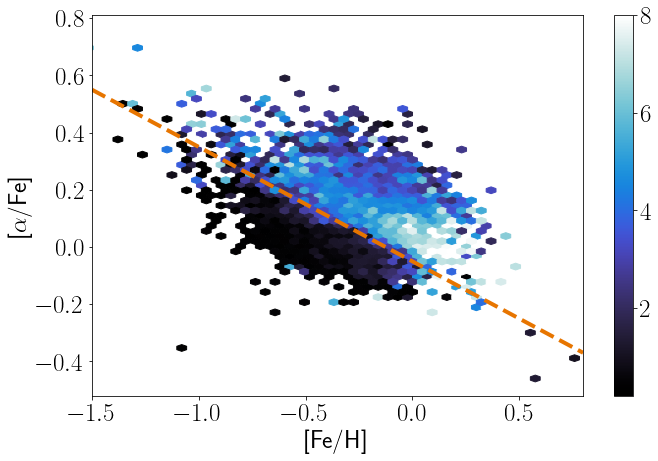

In [40]:
feh = df["fem_gspspec"] + df["mh_gspspec"]

fig, ax = plt.subplots()
# fig.set_facecolor('black')
# ax.set_facecolor('black')
sc = ax.hexbin(
    feh,
    df["alphafe_gspspec"],
    C=df["age_flame"],
    vmax=8,
    cmap=cmr.freeze,
    gridsize=60,
)
ax.set_xlim(-1.5, 0.8)
xr = np.linspace(-1.5, 0.8)
fig.colorbar(sc)
ax.plot(xr, -0.4 * xr - 0.05, c="#e77500", lw=4, ls="--")
ax.set_xlabel("[Fe/H]")
ax.set_ylabel(r"[$\alpha$/Fe]")

In [41]:
o = Orbit(coords)
ts = np.linspace(0.0, 1.0, 1000) * u.Gyr
o.integrate(ts, MWPotential2014, numcores=12)

  0%|          | 0/17032 [00:00<?, ?it/s]

In [42]:
jz = o.jz(MWPotential2014)
jr = o.jr(MWPotential2014)
lz = o.Lz()
jtot = np.sqrt(np.sum(np.square((o.jp(MWPotential2014), jr, jz)), axis=0))

Text(0, 0.5, '$(J_z - J_r) / J_{tot}$')

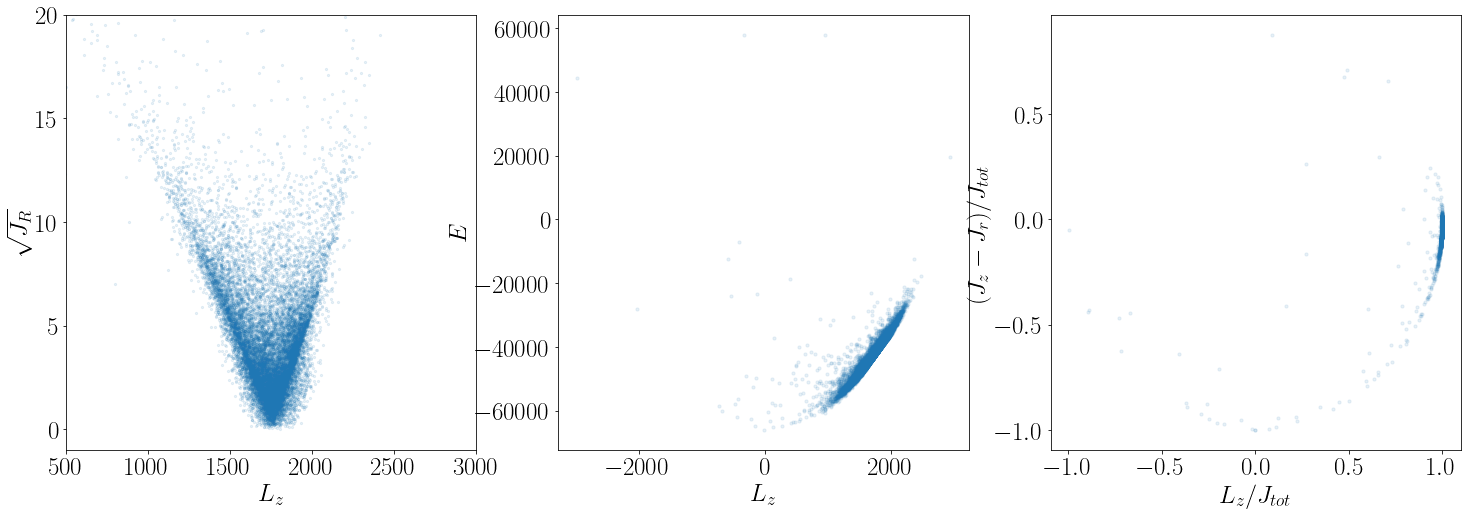

In [43]:
fig = plt.figure(figsize=(25, 8))

ax0 = fig.add_subplot(131)
ax0.scatter(lz, np.sqrt(jr), s=5, alpha=0.1)
ax0.set_ylim(-1, 20)
ax0.set_xlim(500, 3000)
ax0.set_xlabel(r"$L_z$")
ax0.set_ylabel(r"$\sqrt{J_R}$")

ax1 = fig.add_subplot(132)
ax1.scatter(lz, o.E(), s=10, alpha=0.1)
ax1.set_xlabel(r"$L_z$")
ax1.set_ylabel(r"$E$")

ax2 = fig.add_subplot(133)
ax2.scatter(lz / jtot, (jz - jr) / jtot, s=10, alpha=0.1)
ax2.set_xlabel(r"$L_z / J_{tot}$")
ax2.set_ylabel(r"$(J_z - J_r) / J_{tot}$")

In [45]:
o[::500].animate(d1=["x", "vR"], d2=["y", "vT"], width=800)